## Green Roof Survivability Analysis

### Phase 1: TO-Green Roof Permit Data QA and Green Roof Identification

The Green Roof By-law was adopted by Toronto City Council May 2009 under the authority of section 108 of the City of Toronto Act. Toronto is the first city in North America to have a by-law requiring and governing the construction of green roofs. The bylaw applies to new commercial, institutional and many residential development applications and to certain developments not completed before the bylaw came into effect on Jan 31, 2010.

#### Methodological Steps

1.Geocode addresses from Green Roof permit data.
2.Digitize/Identify building roofs with green roof and use these as training data for deep-learning algorithm to extract green-roof outlines
2.1	Explore possibility of identifying “type of roof” from imagery, using paper forms might be better route. 
3.Run trained algorithm on entire city-ortho dataset (current year) and identify any missing/incorrect green roofs currently in existence
4.Use city-wide dataset to do a quality comparison with permit data (from step 1) and identify any issues/errors. 


In [3]:
#Import libraries
import google_streetview.api
import google_streetview.helpers
from geoalchemy2 import Geometry, WKTElement
from sqlalchemy import *
import time
import psycopg2
from shapely.geometry import *
#shapely.speedups.enable()
import subprocess
import sys,os,os.path
import pandas as pd
import geopandas as gpd 
import requests
import pandas as pd
import zipfile
import io
import shapely
import numpy as np
import psycopg2
import networkx as nx
import multiprocessing as mp
import pandana as pdna
import h5py
import shapefile
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from shapely import ops
from shapely import wkt
from shapely.geometry import Polygon, LineString, Point, box
from geoalchemy2 import Geometry, WKTElement
from sqlalchemy import *
from shapely.geometry import *
from fiona.crs import from_epsg
from mpl_toolkits.axes_grid1 import make_axes_locatable
import urllib.request, urllib.parse, urllib.error,urllib.request,urllib.error,urllib.parse
import xmltodict
from io import StringIO
import ogr, osr
from urllib.request import urlopen
import xmltodict
import fiona
from shapely.geometry import shape,mapping
from shapely.ops import transform
from functools import partial
import pyproj
from fiona.crs import from_epsg
import time
from PIL import Image
import itertools
import matplotlib.pyplot as plt
import imageio
%matplotlib inline 
%matplotlib inline

pd.options.display.max_rows = 120

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

/opt/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
# reading Green Roof permit data csv file
greenroof = pd.read_csv('/media/DATADRIVE/data/greenroof/Building Permits - Green Roofs Data.csv', delimiter= ',')

greenroof.tail(2)

,_id,APPLICATION_DATE,COMPLETED_DATE,DESCRIPTION,GREEN_ROOF_AREA,GREEN_ROOF_VARIATION_AREA,ISSUED_DATE,PERMIT_NUM,PERMIT_TYPE,POSTAL,REVISION_NUM,STATUS,STREET_DIRECTION,STREET_NAME,STREET_NUM,STREET_TYPE,STRUCTURE_TYPE
684,7466,2019-07-30,NaN,Proposal to construct a new 50-storey apartmen...,415.5,97.3,NaN,19 198018,New Building,M4Y,0,Under Review,E,CHARLES,55,ST,Apartment Building
685,7467,2019-08-01,NaN,Construction of the maintenance and storage fa...,3668.17,0.0,NaN,19 199071,New Building,,0,Under Review,,YORK GATE,50,BLVD,"Transit Station,Subway, Bus Terminal"


In [29]:
# # reading Green Roof permit data csv file
# greenroof = pd.read_csv('/media/DATADRIVE/data/greenroof/toronto-building-green-roof-permits-csv.csv', delimiter= ',')

# greenroof.tail(2)

# this dataset is old

,_id,PERMIT_NUM,REVISION_NUM,PERMIT_TYPE,STRUCTURE_TYPE,STREET_NUM,STREET_NAME,STREET_TYPE,STREET_DIRECTION,POSTAL,APPLICATION_DATE,ISSUED_DATE,COMPLETED_DATE,STATUS,DESCRIPTION,GREEN_ROOF_AREA,GREEN_ROOF_VARIATION_AREA
621,622,18 270155,00,New Building,Mixed Use/Res w Non Res,628,CHURCH,ST,,M4Y,2018-12-19T00:00:00,NaN,NaN,Under Review,Proposal to construct a 47 storey Mixed Use Bu...,531.3,0
622,623,18 270504,00,Small Residential Projects,SFD - Semi-Detached,72,ROXBOROUGH,ST,W,M5R,2018-12-20T00:00:00,NaN,NaN,Refusal Notice,Proposal to construct detached garage with a g...,50,NaN


In [5]:
# Get Green Roof Address
greenroof['fulladdr'] = greenroof['STREET_NUM'].apply(str) +' '+ greenroof['STREET_NAME']

greenroof.head(2)

,_id,APPLICATION_DATE,COMPLETED_DATE,DESCRIPTION,GREEN_ROOF_AREA,GREEN_ROOF_VARIATION_AREA,ISSUED_DATE,PERMIT_NUM,PERMIT_TYPE,POSTAL,REVISION_NUM,STATUS,STREET_DIRECTION,STREET_NAME,STREET_NUM,STREET_TYPE,STRUCTURE_TYPE,fulladdr
0,6782,2010-02-18,2010-11-29,Revision No.1: To construct a rear one storey ...,18.36,NaN,2010-03-25,03 141785,Small Residential Projects,M8Y,1,Closed,,SOUTH KINGSLEA,4,DR,SFD - Detached,4 SOUTH KINGSLEA
1,6783,2010-12-06,NaN,Revision: Proposal to construct new green roof...,375,0.0,2011-02-11,09 176602,New Building,M5S,1,Revision Issued,,ST GEORGE,97,ST,University,97 ST GEORGE


In [6]:
##greenroof.columns = map(str.lower, greenroof.columns)
greenroof['fulladdr'] = greenroof['fulladdr'].str.lower()
greenroof.head(2)

,_id,APPLICATION_DATE,COMPLETED_DATE,DESCRIPTION,GREEN_ROOF_AREA,GREEN_ROOF_VARIATION_AREA,ISSUED_DATE,PERMIT_NUM,PERMIT_TYPE,POSTAL,REVISION_NUM,STATUS,STREET_DIRECTION,STREET_NAME,STREET_NUM,STREET_TYPE,STRUCTURE_TYPE,fulladdr
0,6782,2010-02-18,2010-11-29,Revision No.1: To construct a rear one storey ...,18.36,NaN,2010-03-25,03 141785,Small Residential Projects,M8Y,1,Closed,,SOUTH KINGSLEA,4,DR,SFD - Detached,4 south kingslea
1,6783,2010-12-06,NaN,Revision: Proposal to construct new green roof...,375,0.0,2011-02-11,09 176602,New Building,M5S,1,Revision Issued,,ST GEORGE,97,ST,University,97 st george


In [11]:
# Reading municipal building data
building = gpd.read_file("/media/DATADRIVE/data/greenroof/Toronto_Buildings.shp")
building.tail(2)

,id,ctuid,ctname,ctnum,geotext,d_fc_0,n_fc_0,d_ff_0,n_ff_0,d_sm_0,n_sm_0,d_hp_0,n_hp_0,d_sxhc_0,n_sxhc_0,d_wc_0,n_wc_0,d_sc_0,n_sc_0,d_ar_0,n_ar_0,d_dc_0,n_dc_0,d_di_0,n_di_0,d_ems_0,n_ems_0,d_fc_1,n_fc_1,d_ff_1,n_ff_1,d_sm_1,n_sm_1,d_hp_1,n_hp_1,d_sxhc_1,n_sxhc_1,d_wc_1,n_wc_1,d_sc_1,n_sc_1,d_ar_1,n_ar_1,d_dc_1,n_dc_1,d_di_1,n_di_1,d_ems_1,n_ems_1,d_frc_0,n_frc_0,d_fr_0,n_fr_0,d_lb_0,n_lb_0,d_plc_0,n_plc_0,d_rec_0,n_rec_0,d_thing_0,n_thing_0,d_vtl_0,n_vtl_0,d_bp_0,n_bp_0,d_bs_0,n_bs_0,d_ttcstop_,n_ttcstop_,d_ttcst_0,n_ttcst_0,d_ttcacc_0,n_ttcacc_0,d_frc_1,n_frc_1,d_fr_1,n_fr_1,d_lb_1,n_lb_1,d_plc_1,n_plc_1,d_rec_1,n_rec_1,d_thing_1,n_thing_1,d_vtl_1,n_vtl_1,d_bp_1,n_bp_1,d_bs_1,n_bs_1,d_ttcsto_1,n_ttcsto_1,d_ttcst_1,n_ttcst_1,d_ttcacc_1,n_ttcacc_1,m_fc_0,m_fc_1,m_ff_0,m_ff_1,m_sm_0,m_sm_1,m_hp_0,m_hp_1,m_sxhc_0,m_sxhc_1,m_wc_0,m_wc_1,m_sc_0,m_sc_1,m_ar_0,m_ar_1,m_dc_0,m_dc_1,m_di_0,m_di_1,m_ems_0,m_ems_1,m_frc_0,m_frc_1,m_fr_0,m_fr_1,m_lb_0,m_lb_1,m_plc_0,m_plc_1,m_rec_0,m_rec_1,m_thing_0,m_thing_1,m_vtl_0,m_vtl_1,m_bp_0,m_bp_1,m_bs_0,m_bs_1,m_ttcstop_,m_ttcsto_1,m_ttcst_0,m_ttcst_1,m_ttcacc_0,m_ttcacc_1,n_fc_0n,n_fc_0type,n_ff_0n,n_ff_0type,n_sm_0n,n_sm_0type,n_hp_0n,n_hp_0type,n_sxhc_0n,n_sxhc_0ty,n_wc_0n,n_wc_0type,n_sc_0n,n_ar_0n,n_ar_0type,n_lb_0n,n_dc_0n,n_dc_0type,n_fr_0n,n_fr_0type,n_di_0n,n_ems_0n,n_ems_0typ,n_frc_0n,n_frc_0typ,n_plc_0n,n_plc_0typ,n_rec_0n,n_rec_0typ,n_thing_0n,n_thing_0t,n_vtl_0n,n_vtl_0typ,n_bp_0type,n_bs_0type,n_ttcsto_2,n_ttcsto_3,n_ttcst_0n,n_ttcst_0t,n_ttcacc_2,n_ttcacc_3,n_fc_1n,n_fc_1type,n_ff_1n,n_ff_1type,n_sm_1n,n_sm_1type,n_hp_1n,n_hp_1type,n_sxhc_1n,n_lb_1type,n_wc_1n,n_wc_1type,n_sc_1n,n_ar_1n,n_dc_1n,n_dc_1type,n_lb_1n,n_fr_1n,n_fr_1type,n_di_1n,n_ems_1n,n_ems_1typ,n_frc_1n,n_frc_1typ,n_plc_1n,n_plc_1typ,n_rec_1n,n_rec_1typ,n_thing_1n,n_thing_1t,n_vtl_1n,n_vtl_1typ,n_bp_1type,n_bs_1type,n_ttcsto_4,n_ttcsto_5,n_ttcst_1n,n_ttcst_1t,n_ttcacc_4,n_ttcacc_5,geometry
394473,41753,5350313.0,313.0,535031300.0,535031300,588.728027,595.0,1152.438965,3472.0,2162.208984,139.0,3248.59790,13.0,4142.775879,2.0,2154.785889,5.0,230.994003,1071.0,1678.633057,17.0,230.994003,461.0,4559.548828,4.0,2444.552002,38.0,653.843018,901.0,1152.438965,2625.0,2316.314941,436.0,5000.0,NaN,4383.056152,9.0,2680.850098,4.0,808.859009,859.0,3226.509033,15.0,808.859009,839.0,5000.0,NaN,2503.698975,21.0,230.994003,132.0,2603.574951,41.0,755.068970,15.0,2265.365967,8.0,1590.293945,21.0,2495.247070,89.0,230.994003,1253.0,5000.0,NaN,5000.0,NaN,599.971008,1554.0,5000.0,NaN,5000.0,NaN,2004.437988,71.0,3845.075928,77.0,3383.577881,60.0,2803.326904,29.0,2379.229004,92.0,2626.576904,106.0,808.859009,1329.0,5000.0,NaN,5000.0,None,599.971008,7990.0,5000.0,NaN,5000.0,NaN,8.176778,9.081153,16.006097,16.006097,30.03068,32.171041,45.119415,69.444444,57.538554,60.875780,29.927582,37.234029,3.208250,11.234153,23.314348,44.812625,3.208250,11.234153,63.327067,69.444444,33.952111,34.773597,3.208250,27.839417,36.160763,53.403832,10.487069,46.994137,31.463416,38.935096,22.087416,33.044847,34.656209,36.480235,3.208250,11.234153,69.444444,69.444444,69.444444,69.444444,8.332931,8.332931,69.444444,69.444444,69.444444,69.444444,Weston Gift & Variety,cs,None,None,AMBER BAKERY,sm,Etobicoke General Hospital,h,Black Creek Community Health Centre (Sheridan ...,Humber River-Black Creek (7),Albion Medical Centre,w,GULFSTREAM PUBLIC SCHOOL,Goulding Park,North York,Woodview Park Public Library,Holy Spirit Jr Ymca,Holy Spirit Catholic School,FIRE STATION 346 CNE,90 QUEBEC ST,WoodGreen Drop-In,TPS 43 Division/EMS Stn 26,"Toronto Police 43 Div, Ambulance Sta 26",West Hill Adult Child Centre,West Hill Community Services,Police Dog Services,44 Beechwood Avenue,"Elms, The",Swimming Pools,The Assembly Hall,Art Exhibits,Daystrom Public School,Daystrom Dr,None,None,GRENOBLE DR AT VENDOME PL WEST SIDE,3694,None,None,None,None,7 Day Convenience,cs,None,None,HOMELAND WEST INDIAN SUPERMARKET,sm,None,None,Rexdale Community Health Center,Etobicoke North (1),Albany Medical

In [12]:
building.crs

{'init': 'epsg:4326'}

In [9]:
# reading municipal address point shape file
address = gpd.read_file("zip:///home/asulaim/municipal-address-points-wgs84-latitude-longitude.zip")
address.head(2)

,GEO_ID,LINK,MAINT_STAG,ADDRESS,LFNAME,LONUM,LONUMSUF,HINUM,HINUMSUF,ARC_SIDE,DISTANCE,FCODE,FCODE_DES,CLASS,NAME,X,Y,LONGITUDE,LATITUDE,OBJECTID,MUN_NAME,WARD_NAME,geometry
0,1015200,914764,REGULAR,22,Lloyd George Ave,22,None,0,None,L,78.08,100001,Low Density Residential,Land,None,301211.152,4827985.051,-79.544251,43.593789,4104309.0,Etobicoke,Etobicoke-Lakeshore,POINT (-79.544251409 43.593788977)
1,1015189,914764,REGULAR,3,Lloyd George Ave,3,None,0,None,R,22.96,100001,Low Density Residential,Land,None,301272.174,4827946.759,-79.543495,43.593445,4104306.0,Etobicoke,Etobicoke-Lakeshore,POINT (-79.543495353 43.59344452)


In [10]:
address.crs

{'init': 'epsg:4326'}

In [37]:
# change column names from upper to lower case
#adress.columns = map(str.lower, address.columns)

#include columns needed for the project
#address = address[['geo_id', 'maint_stag','address','lfname','x','y','longitude','latitude','objectid','mun_name','ward_name','geometry']]
#adress.head(2)

In [8]:
# Get Address Point Address
address['fulladdr'] = address['ADDRESS'].apply(str) +' '+ address['LFNAME']
address['fulladdr'] = address['fulladdr'].str.lower()
address.tail(2)

,GEO_ID,LINK,MAINT_STAG,ADDRESS,LFNAME,LONUM,LONUMSUF,HINUM,HINUMSUF,ARC_SIDE,DISTANCE,FCODE,FCODE_DES,CLASS,NAME,X,Y,LONGITUDE,LATITUDE,OBJECTID,MUN_NAME,WARD_NAME,geometry,fulladdr
525543,30113758,30058626,RESERVED,4638,Eglinton Ave W,4638,None,0,None,R,162.39,112001,Commercial Location,Structure,None,300966.026,4837490.537,-79.547354,43.679349,4328458.0,Etobicoke,Etobicoke Centre,POINT (-79.547354052 43.679348884),4638 eglinton ave w
525544,13972694,105545,REGULAR,50,Castle Hill Dr,50,None,0,None,L,38.20,106001,Municipal Park,Land,Highland Heights Park,321035.697,4850477.891,-79.298051,43.796085,4285179.0,Scarborough,Scarborough-Agincourt,POINT (-79.298051259 43.796085141),50 castle hill dr


In [21]:
#greenroofaddress = pd.merge(address, greenroof, how='inner',  on=['fulladdr'])
greenroofaddress = pd.concat([address, greenroof], axis=1, join='inner')

In [22]:
greenroofaddress.tail(2) 

,GEO_ID,LINK,MAINT_STAG,ADDRESS,LFNAME,LONUM,LONUMSUF,HINUM,HINUMSUF,ARC_SIDE,DISTANCE,FCODE,FCODE_DES,CLASS,NAME,X,Y,LONGITUDE,LATITUDE,OBJECTID,MUN_NAME,WARD_NAME,geometry,_id,APPLICATION_DATE,COMPLETED_DATE,DESCRIPTION,GREEN_ROOF_AREA,GREEN_ROOF_VARIATION_AREA,ISSUED_DATE,PERMIT_NUM,PERMIT_TYPE,POSTAL,REVISION_NUM,STATUS,STREET_DIRECTION,STREET_NAME,STREET_NUM,STREET_TYPE,STRUCTURE_TYPE,fulladdr
684,996971,914688,REGULAR,23,Dover Dr,23,None,0,None,L,134.80,100001,Low Density Residential,Land,None,301225.717,4828143.657,-79.544075,43.595225,1570006.0,Etobicoke,Etobicoke-Lakeshore,POINT (-79.54407531951971 43.5952253159965),7466,2019-07-30,NaN,Proposal to construct a new 50-storey apartmen...,415.5,97.3,NaN,19 198018,New Building,M4Y,0,Under Review,E,CHARLES,55,ST,Apartment Building,55 charles
685,9950033,9950011,REGULAR,18,Alcan Ave,18,None,0,None,R,116.67,115001,Unknown,Land,None,301249.630,4828078.588,-79.543779,43.594640,2679164.0,Etobicoke,Etobicoke-Lakeshore,POINT (-79.54377869343131 43.5946396352119),7467,2019-08-01,NaN,Construction of the maintenance and storage fa...,3668.17,0.0,NaN,19 199071,New Building,,0,Under Review,,YORK GATE,50,BLVD,"Transit Station,Subway, Bus Terminal",50 york gate


In [11]:
greenroofaddress['Coordinates'] = list(zip(greenroofaddress.LONGITUDE, greenroofaddress.LATITUDE))
greenroofaddress['Coordinates'] = greenroofaddress['Coordinates'].apply(Point)
crs = {'init': 'epsg:4326'}
greenroofaddress = gpd.GeoDataFrame(greenroofaddress, crs=crs, geometry='Coordinates')
greenroofaddress = greenroofaddress.to_crs({'init': 'epsg:4326'})

In [14]:
ortho.head(2)

,Tile_Name,geometry
0,OCA1,"POLYGON ((320000 4834500, 320000 4835000, 3205..."
1,OCA2,"POLYGON ((320500 4834500, 320500 4835000, 3210..."


In [13]:
# Reading municipal building data
ortho = gpd.read_file("/media/DATADRIVE/data/greenroof/OrthoIndex.shp")
ortho.crs

{'proj': 'tmerc',
 'lat_0': 0,
 'lon_0': -79.5,
 'k': 0.9999,
 'x_0': 304800,
 'y_0': 0,
 'datum': 'NAD27',
 'units': 'm',
 'no_defs': True}

In [16]:
crs = {'init': 'epsg:4326'}
ortho = gpd.GeoDataFrame(ortho, crs=crs, geometry='geometry')
ortho = ortho.to_crs({'init': 'epsg:4326'})

In [17]:
ortho.crs

{'init': 'epsg:4326'}

Text(0.5, 1.0, 'Toronto Green Roofs By-law')

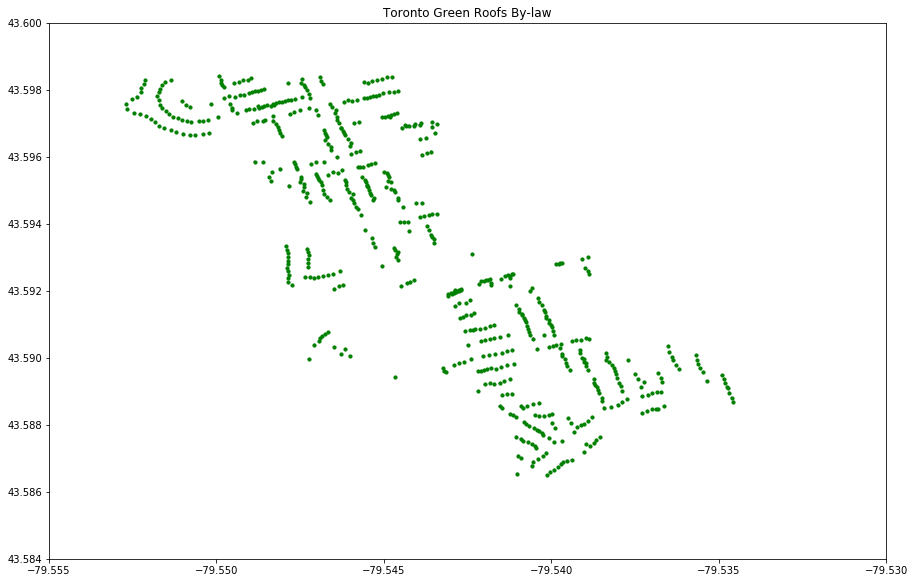

In [12]:
ax = greenroofaddress.plot(figsize=(15, 15), legend=True, markersize = 1, cmap='viridis')
ax.set(xlim=(-79.555, -79.530), ylim=(43.584, 43.60))
greenroofaddress.plot(ax=ax, color='green', markersize =10)
plt.title('Toronto Green Roofs By-law')

In [13]:
# intersecting greenroofaddress with buildings
building = building.to_crs({'init': 'epsg:4326'})
greenroofaddress=greenroofaddress.to_crs({'init': 'epsg:4326'})
#greenroofbuildings = gpd.sjoin(building, greenroofaddress, op='within')